In [1]:
from sklearn.dummy import DummyClassifier
import torch
import torch.nn as nn
import torch.optim as optim
from torch import Tensor
from typing import Type
from torch.optim import lr_scheduler
from torch.nn import Module,Linear,Sequential,ReLU,ELU,Dropout,BatchNorm1d,Flatten,CrossEntropyLoss,Conv2d,MaxPool2d
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import os
import sys
import random
import copy
import time
import shutil
import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary
from sklearn import metrics
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from pandas import DataFrame
import seaborn as sn
import numpy as np
import PIL
from collections import Counter
import matplotlib.pyplot as plt
from IPython.display import clear_output


In [2]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [3]:
BATCH=300
DATASET_VARIANT= "byclass" # "balanced" #    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
import torchvision.datasets
MNIST_train = torchvision.datasets.EMNIST('./', download=True, train=True,split=DATASET_VARIANT,transform=transforms.Compose([lambda img: torchvision.transforms.functional.rotate(img, -90),
                                                                    transforms.RandomHorizontalFlip(p=1),
                                                                     transforms.Pad(2),                                                   
                                                                    transforms.ToTensor()]))
MNIST_test = torchvision.datasets.EMNIST('./', download=True, train=False,split=DATASET_VARIANT,transform=transforms.Compose([lambda img: torchvision.transforms.functional.rotate(img, -90),
                                                                    transforms.RandomHorizontalFlip(p=1),
                                                                     transforms.Pad(2),
                                                                    transforms.ToTensor()]))
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels
X_train = X_train.float()
X_test = X_test.float()

/opt/jupyter_venvs/mipt_venv/lib64/python3.11/site-packages/torchvision/datasets/mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/opt/jupyter_venvs/mipt_venv/lib64/python3.11/site-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/opt/jupyter_venvs/mipt_venv/lib64/python3.11/site-packages/torchvision/datasets/mnist.py:81: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/opt/jupyter_venvs/mipt_venv/lib64/python3.11/site-packages/torchvision/datasets/mnist.py:71: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


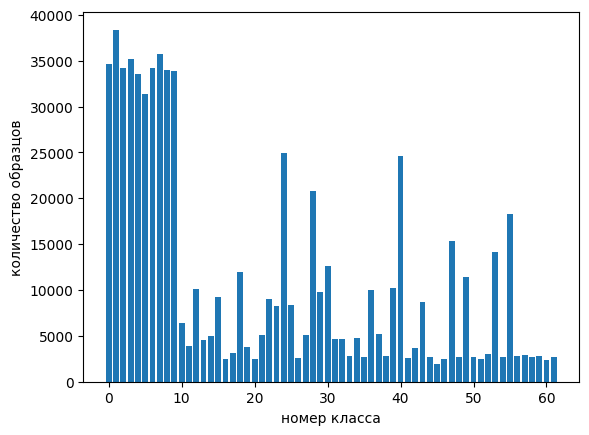

In [5]:
if __name__ == "__main__":
    counter=Counter(y_train.numpy())
    nums=np.array(sorted(counter.items()))[:,1]
    labels=np.array(sorted(counter.items()))[:,0]
    plt.bar(labels,nums)
    plt.xlabel("номер класса")
    plt.ylabel("количество образцов")
    plt.savefig("images/emnist_"+DATASET_VARIANT+".png",  bbox_inches='tight', pad_inches=0)

In [6]:
def imshow(img,i):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.savefig("images/emnist_"+i+"_images.png",  bbox_inches='tight', pad_inches=0)
    plt.show()
    
def show_img_with_gt(i):
    batch_size=16
    dset_tr = torchvision.datasets.EMNIST('./', download=True, train=True,split=i,
                                              transform=transforms.Compose([lambda img: torchvision.transforms.functional.rotate(img, -90),
                                                                    transforms.RandomHorizontalFlip(p=1),
                                                                     transforms.Pad(2),                                                   
                                                                    transforms.ToTensor()]))
    dset_loader = torch.utils.data.DataLoader(dset_tr, batch_size=batch_size)
    _, (image, label) = next(enumerate(dset_loader))
    print(image.shape)
    imshow(torchvision.utils.make_grid(image),i)
    print('GroundTruth: ', ' '.join('%5s' % dset_tr.classes[label[j]] for j in range(batch_size)))


torch.Size([16, 1, 32, 32])


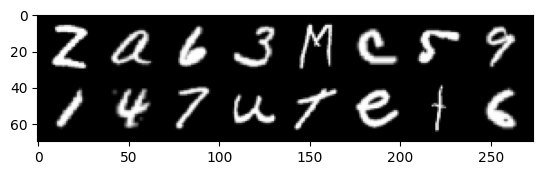

GroundTruth:      Z     a     6     3     M     c     5     9     l     4     7     u     T     e     t     6
torch.Size([16, 1, 32, 32])


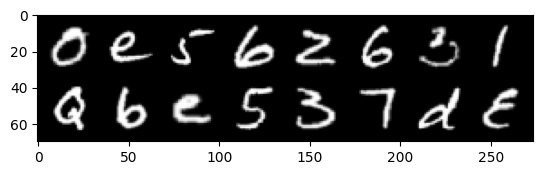

GroundTruth:      O     a     5     6     Z     6     3     1     Q     b     e     5     3     7     d     E
torch.Size([16, 1, 32, 32])


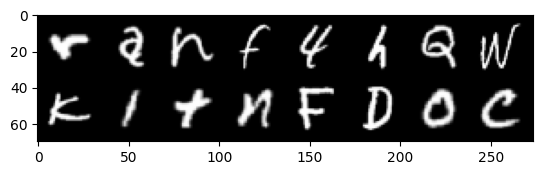

GroundTruth:      r     a     n     F     4     h     Q     W     K     1     t     n     F     D     O     C
torch.Size([16, 1, 32, 32])


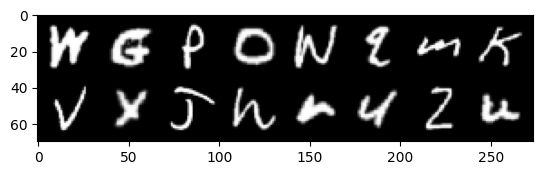

GroundTruth:      w     g     p     o     w     q     m     k     v     x     j     n     r     u     z     u
torch.Size([16, 1, 32, 32])


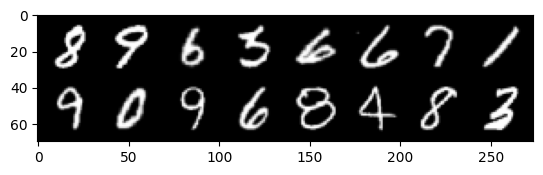

GroundTruth:      8     9     6     3     6     6     7     1     9     0     9     6     8     4     8     3
torch.Size([16, 1, 32, 32])


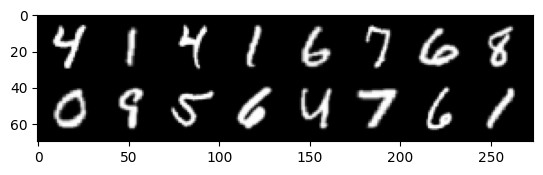

GroundTruth:      4     1     4     1     6     7     6     8     0     9     5     6     4     7     6     1


In [7]:
if __name__ == "__main__":
    show_img_with_gt("byclass")
    show_img_with_gt("bymerge")
    show_img_with_gt("balanced")
    show_img_with_gt("letters")
    show_img_with_gt("digits")
    show_img_with_gt("mnist")

In [8]:
image_datasets = {"train":torchvision.datasets.EMNIST('./', download=True, train=True,split=DATASET_VARIANT,
                                              transform=transforms.Compose([lambda img: torchvision.transforms.functional.rotate(img, -90),
                                                                    transforms.RandomHorizontalFlip(p=1),
                                                                     transforms.Pad(2),                                                   
                                                                    transforms.ToTensor()])),
                  "val":torchvision.datasets.EMNIST('./', download=True, train=False,split=DATASET_VARIANT,
                                              transform=transforms.Compose([lambda img: torchvision.transforms.functional.rotate(img, -90),
                                                                    transforms.RandomHorizontalFlip(p=1),
                                                                     transforms.Pad(2),                                                   
                                                                    transforms.ToTensor()]))
}
dataloaders = {"train":torch.utils.data.DataLoader(image_datasets["train"], batch_size=BATCH),
               "val":torch.utils.data.DataLoader(image_datasets["val"], batch_size=BATCH)
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes              

In [9]:
class Trainer():
    @staticmethod
    def getActivateFunction(name):
        if name == 'rrelu':
            return torch.nn.RReLU()
        elif name == 'relu':
            return torch.nn.ReLU()
        elif name == 'lrelu':
            return torch.nn.LeakyReLU()
        elif name == 'hardswish':
            return torch.nn.Hardswish()
        else:
            return torch.nn.Tanh()

    @staticmethod
    def train_model(model, dtloaders, criterion, optimizer, scheduler, num_epochs=10, net_name="none"):
        best_model_wts = copy.deepcopy(model.state_dict())
        best_epoch=0; best_acc = 0.0; best_loss = sys.maxsize
        hist_loss_train = []; hist_acc_train = [] 
        hist_loss_val = []; hist_acc_val = []

        for epoch in range(num_epochs):    # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode
                running_loss = 0.0
                running_corrects = 0            
                for inputs, labels in dtloaders[phase]:    # Iterate over data.
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    optimizer.zero_grad()
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs,labels)
                        if phase == 'train':     # backward + optimize only if in training phase
                            loss.backward()
                            optimizer.step()
                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()
                epoch_loss = running_loss / len(dtloaders[phase].dataset)
                epoch_acc = running_corrects.double() / len(dtloaders[phase].dataset)
                if phase == 'train':
                    hist_loss_train.append(epoch_loss)
                    hist_acc_train.append(epoch_acc.cpu().item())
                else:     
                    hist_loss_val.append(epoch_loss)
                    hist_acc_val.append(epoch_acc.cpu().item())
                # deep copy the model
                if phase == 'val' and epoch_loss < best_loss:
                    best_acc = epoch_acc.item()
                    best_loss = epoch_loss
                    best_epoch = epoch
                    best_model_wts = copy.deepcopy(model.state_dict())
            clear_output(True)   
            plt.plot(hist_loss_train,label='hist_loss_train ({})'.format(round(hist_loss_train[-1],2)))
            plt.plot(hist_loss_val,label='hist_loss_val ({})'.format(round(hist_loss_val[-1],2)))
            plt.legend(framealpha=1, frameon=True);
            plt.title('Loss (epoch {}/{})'.format(epoch,num_epochs))
            plt.xlabel('эпохи')
            plt.ylabel('потери')
            plt.savefig("images/"+net_name+"_loss.png",  bbox_inches='tight', pad_inches=0)
            plt.show()
        model.eval()
        plt.plot(hist_acc_train,label='hist_acc_train')
        plt.plot(hist_acc_val,label='hist_acc_val')
        plt.legend(framealpha=1, frameon=True);
        plt.title('Acc')
        plt.xlabel('эпохи')
        plt.ylabel('точность')
        plt.savefig("images/"+net_name+"_acc.png",  bbox_inches='tight', pad_inches=0)
        plt.show()
        model.load_state_dict(best_model_wts)     # load best model weights
        return model,best_acc


trainer = Trainer()

## Fully-connected Net

In [14]:
class FCNet(nn.Module):

    def __init__(self, num_inputs, num_classes):    
        super(self.__class__,self).__init__()
        self.flat = torch.nn.Flatten()
        self.fc = nn.Linear(num_inputs , num_classes)

    def forward(self, x):
        x=self.flat(x)
        x=self.fc(x)
        return x
fcnet = FCNet(32*32,num_classes=len(image_datasets["train"].classes)).to(device)
if __name__ == "__main__": print(fcnet)

FCNet(
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=1024, out_features=62, bias=True)
)


In [15]:
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(fcnet.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

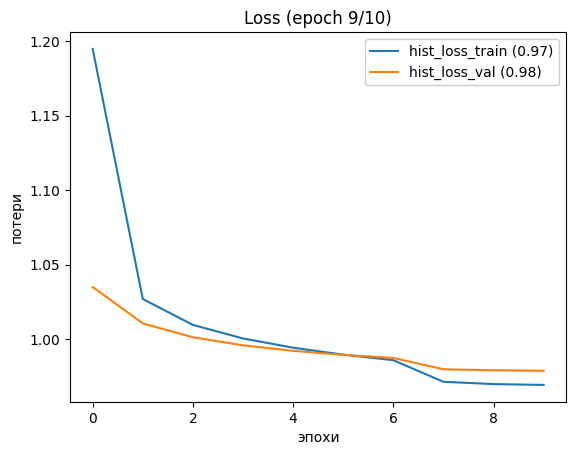

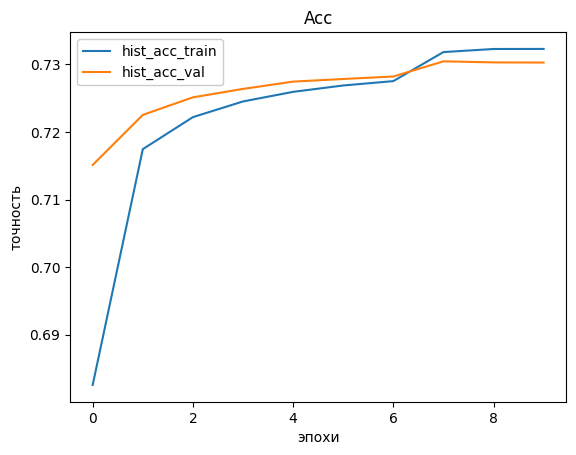

Train time:1426.5866639614105
Best acc:0.7302769013866561


In [16]:
if __name__ == "__main__":
    start = time.time()
    model,acc=Trainer.train_model(fcnet, dataloaders,criterion, optimizer_ft, exp_lr_scheduler, 
                          num_epochs=10,net_name="fcnet_"+DATASET_VARIANT)
    end = time.time()
    print("Train time:{}".format(end - start))
    print("Best acc:{}".format(acc))

In [17]:
torch.save(fcnet.state_dict(), "models/emnist_fcnet_"+DATASET_VARIANT+".pt")
fcnet.load_state_dict(torch.load("models/emnist_fcnet_"+DATASET_VARIANT+".pt"))

<All keys matched successfully>

In [19]:
#510Mb
# balanced
#  Train time:239.2531886100769
#  Best acc:0.6905851063829788
# byclass
# Train time:1459.2439579963684
# Best acc:0.7303026916430972

## LeNet-5

In [20]:
class LeNet(nn.Module):

    def __init__(self,num_classes):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5*5 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = F.max_pool2d(F.tanh(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.tanh(self.conv2(x)), 2)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

lenet = LeNet(num_classes=len(image_datasets["train"].classes)).to(device)
if __name__ == "__main__": print(lenet)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=62, bias=True)
)


In [21]:
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(lenet.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

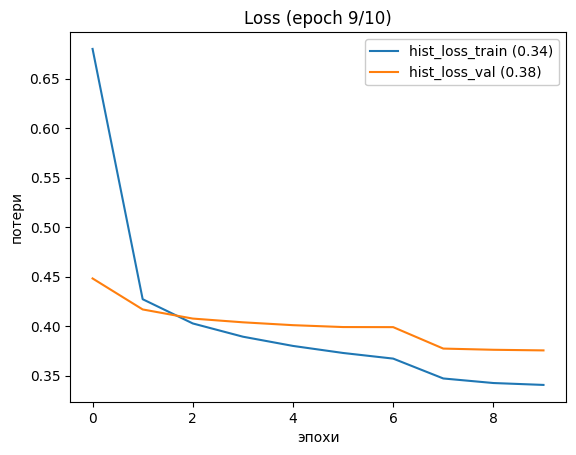

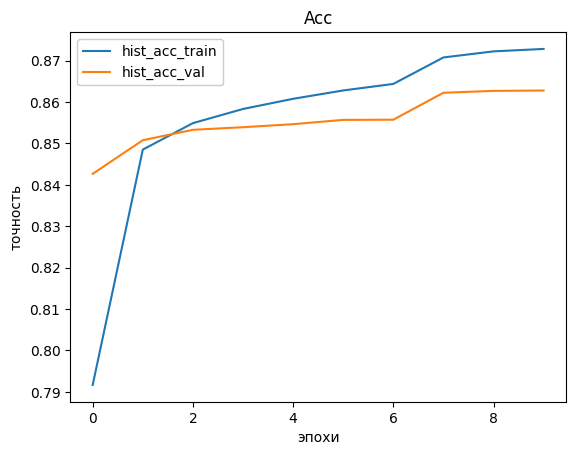

Train time:1609.8897426128387
Best acc:0.86279583573326


In [22]:
if __name__ == "__main__":
    start = time.time()
    model,acc=trainer.train_model(lenet, dataloaders,criterion, optimizer_ft, exp_lr_scheduler, 
                          num_epochs=10,net_name="lenet_"+DATASET_VARIANT)
    end = time.time()
    print("Train time:{}".format(end - start))
    print("Best acc:{}".format(acc))

In [23]:
torch.save(lenet.state_dict(), "models/emnist_lenet_"+DATASET_VARIANT+".pt")
lenet.load_state_dict(torch.load("models/emnist_lenet_"+DATASET_VARIANT+".pt"))

<All keys matched successfully>

In [24]:
if __name__ == "__main__":
    summary(lenet,(1,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
            Conv2d-2           [-1, 16, 10, 10]           2,416
            Linear-3                  [-1, 120]          48,120
            Linear-4                   [-1, 84]          10,164
            Linear-5                   [-1, 62]           5,270
Total params: 66,126
Trainable params: 66,126
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.25
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


In [25]:
#716M
# balanced
#  Train time:268.60275316238403
#  Best acc:0.8658510638297873
# by_class
#  Train time:1633.808830022812
#  Best acc:0.861454742398322

## DummyClassifier

In [26]:
if __name__ == "__main__":
    model = DummyClassifier(strategy='uniform')
    with ignore_warnings(category=ConvergenceWarning):
        model.fit(X_train, y_train)
    print("Acc: {}".format(model.score(X_test, y_test)))

Acc: 0.016032942754227453


## ResNet

In [27]:
class BasicBlock(nn.Module):
    def __init__(self, in_ch, out_ch, stride = 1, expansion = 1, downsample = None):
        super(BasicBlock, self).__init__()
        self.expansion = expansion
        self.downsample = downsample
        self.conv1 = nn.Conv2d( in_ch, out_ch, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d( out_ch, out_ch*self.expansion, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_ch*self.expansion)
    def forward(self, x: Tensor) -> Tensor:
        identity = x
        out = self.bn2(self.conv2(self.relu(self.bn1(self.conv1(x)))))
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out    

In [28]:
class MyResNet(nn.Module):
    def __init__(self, img_channels=3, num_layers=18, block=Type[BasicBlock],
        num_classes  = 1000):
        super(MyResNet, self).__init__()
        if num_layers == 18:
            layers = [2, 2, 2, 2]
            self.expansion = 1
        self.in_ch = 64
        self.conv1 = nn.Conv2d(in_channels=img_channels, out_channels=self.in_ch,
            kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_ch)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512*self.expansion, num_classes)
    def _make_layer(self, block, out_ch, blocks, stride = 1):
        downsample = None
        if stride != 1:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_ch, out_ch*self.expansion, kernel_size=1,
                    stride=stride, bias=False),
                nn.BatchNorm2d(out_ch * self.expansion),
            )
        layers = []
        layers.append(block(self.in_ch, out_ch, stride, self.expansion, downsample))
        self.in_ch = out_ch * self.expansion
        for i in range(1, blocks):
            layers.append(block(self.in_ch, out_ch, expansion=self.expansion))
        return nn.Sequential(*layers)
    def forward(self, x: Tensor) -> Tensor:
        x = self.maxpool(self.relu(self.bn1(self.conv1(x))))
        x = self.layer4(self.layer3(self.layer2(self.layer1(x))))
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [29]:
myResNet=MyResNet(1,18, BasicBlock,num_classes=len(image_datasets["train"].classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(myResNet.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

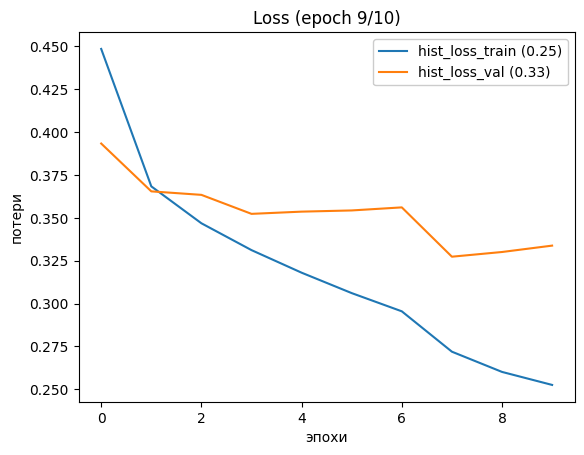

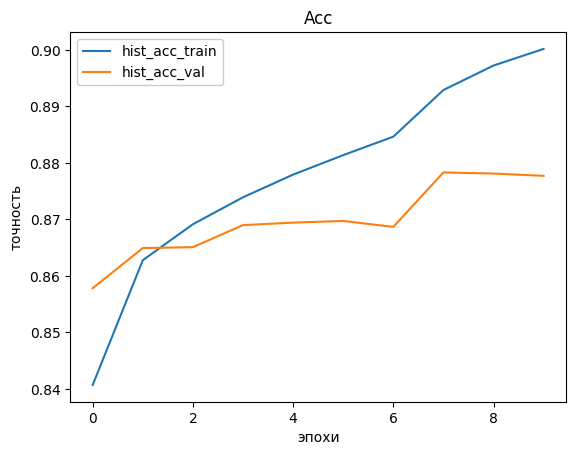

Train time:6392.499420642853
Best acc:0.878295779854371


In [30]:
if __name__ == "__main__":
    start = time.time()
    model,acc=trainer.train_model(myResNet, dataloaders, criterion, optimizer_ft, exp_lr_scheduler, 
                          num_epochs=10,net_name="resnet_"+DATASET_VARIANT)
    end = time.time()
    print("Train time:{}".format(end - start))
    print("Best acc:{}".format(acc))

In [31]:
torch.save(myResNet.state_dict(), "models/emnist_myResNet_"+DATASET_VARIANT+".pt")
myResNet.load_state_dict(torch.load("models/emnist_myResNet_"+DATASET_VARIANT+".pt"))

<All keys matched successfully>

In [32]:
if __name__ == "__main__":
    summary(myResNet,(1,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           3,136
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

In [33]:
#1096M
# balanced
#  Train time:1046.6461882591248
#  Best acc:0.8969148936170213
# by_class 
#  Train time:6470.990069150925
#  Best acc:0.8791038745561927